<a href="https://colab.research.google.com/github/Prince125047/brain_tumor_detection/blob/main/brain_tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/final_augmented_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: final_augmented_dataset/Training/notumor/aug_Tr-no_1105.jpg  
  inflating: final_augmented_dataset/Training/notumor/aug_Tr-no_1106.jpg  
  inflating: final_augmented_dataset/Training/notumor/aug_Tr-no_1107.jpg  
  inflating: final_augmented_dataset/Training/notumor/aug_Tr-no_1108.jpg  
  inflating: final_augmented_dataset/Training/notumor/aug_Tr-no_1109.jpg  
  inflating: final_augmented_dataset/Training/notumor/aug_Tr-no_1110.jpg  
  inflating: final_augmented_dataset/Training/notumor/aug_Tr-no_1111.jpg  
  inflating: final_augmented_dataset/Training/notumor/aug_Tr-no_1112.jpg  
  inflating: final_augmented_dataset/Training/notumor/aug_Tr-no_1113.jpg  
  inflating: final_augmented_dataset/Training/notumor/aug_Tr-no_1114.jpg  
  inflating: final_augmented_dataset/Training/notumor/aug_Tr-no_1115.jpg  
  inflating: final_augmented_dataset/Training/notumor/aug_Tr-no_1116.jpg  
  inflating: final_augmented_dataset/Training/not

##  Data Preparation for Brain Tumor Classification

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data generator with validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    '/content/final_augmented_dataset/Training',
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    '/content/final_augmented_dataset/Training',
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

# Test generator (no split needed)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/final_augmented_dataset/Testing',
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    shuffle=False  # No shuffle for evaluation
)

Found 9141 images belonging to 4 classes.
Found 2283 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


##  CNN + CBAM Model for Brain Tumor Classification

This model integrates a Convolutional Neural Network (CNN) with a **CBAM (Convolutional Block Attention Module)** to enhance focus on critical regions in brain MRI scans. CBAM improves feature learning through two attention mechanisms:

---

###  CBAM Overview

CBAM sequentially applies:

- **Channel Attention**: Learns **what** features are important.
- **Spatial Attention**: Learns **where** in the image to focus.

This helps the model attend more to tumor regions while suppressing irrelevant background.

![CBAM Structure](https://www.researchgate.net/profile/Pendar-Alirezazadeh/publication/366357680/figure/fig1/AS:1142358473451520@1671447209263/The-Convolutional-Block-Attention-Module-CBAM-The-upper-side-is-the-channel-attention.png)


---

###  Model Flow

1. Input MRI image (256×256×3).
2. CNN layers extract features (Conv + MaxPooling).
3. **CBAM block** refines features.
4. Flatten + Dense layers → Softmax for classification into 4 tumor types.

![CNN + CBAM Architecture](https://www.researchgate.net/profile/Yahya-Tashtoush/publication/364780626/figure/fig2/AS:1142358473451520@1671447209263/The-architecture-of-the-CNN-CBAM-model.png)

---

### ⚙️ Usage Notes

- `sparse_categorical_crossentropy` is used since labels are integer-encoded.
- Model is built using Keras Functional API for flexibility.
- Dropout helps prevent overfitting.



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

# --- CBAM Attention Block ---
def cbam_block(input_feature, ratio=8):
    """Convolutional Block Attention Module (CBAM)"""

    channel = input_feature.shape[-1]

    # Channel Attention
    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    max_pool = layers.GlobalMaxPooling2D()(input_feature)

    shared_dense_one = layers.Dense(channel // ratio, activation='relu')
    shared_dense_two = layers.Dense(channel)

    avg_out = shared_dense_one(avg_pool)
    avg_out = shared_dense_two(avg_out)

    max_out = shared_dense_one(max_pool)
    max_out = shared_dense_two(max_out)

    channel_attention = layers.Add()([avg_out, max_out])
    channel_attention = layers.Activation('sigmoid')(channel_attention)
    channel_attention = layers.Reshape((1, 1, channel))(channel_attention)
    x = layers.Multiply()([input_feature, channel_attention])

    # Spatial Attention
    avg_pool_spatial = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(x)
    max_pool_spatial = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(x)
    concat = layers.Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    spatial_attention = layers.Conv2D(1, (7,7), padding='same', activation='sigmoid')(concat)

    refined_feature = layers.Multiply()([x, spatial_attention])

    return refined_feature

# --- CNN + CBAM Model ---
def build_cnn_cbam_model(input_shape=(256, 256, 3), num_classes=4):
    inputs = Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Insert CBAM Attention Block
    x = cbam_block(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# --- Build the model ---
model = build_cnn_cbam_model()

# --- Compile the model ---
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# --- Model Summary ---
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ max_pooling2d_2[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ max_pooling2d_2[… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │      2,064 │ global_average_p… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      2,176 │ dense[0][0],      │
│                     │                   │            │ dense[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128)       │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_1[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128)       │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 128) │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 32, 32,    │          0 │ max_pooling2d_2[… │
│                     │ 128)              │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 32, 32, 1) │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 32, 32, 1) │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32, 2) │          0 │ lambda[0][0],   

 Total params: 67,209,015 (256.38 MB)

 Trainable params: 67,209,015 (256.38 MB)

 Non-trainable params: 0 (0.00 B)

## Training the Model

Start training the CNN + CBAM model using the training and validation generators.


In [ ]:
# --- Training the model ---

epochs = 15
batch_size = 32

# Fit the model using generators
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    batch_size=batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.4892 - loss: 1.1005 - val_accuracy: 0.7311 - val_loss: 0.7046
Epoch 2/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.7684 - loss: 0.5942 - val_accuracy: 0.8524 - val_loss: 0.4262
Epoch 3/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 26s 92ms/step - accuracy: 0.8698 - loss: 0.3430 - val_accuracy: 0.8791 - val_loss: 0.3568
Epoch 4/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.9303 - loss: 0.1904 - val_accuracy: 0.8892 - val_loss: 0.3672
Epoch 5/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 42s 93ms/step - accuracy: 0.9650 - loss: 0.1010 - val_accuracy: 0.8782 - val_loss: 0.4531
Epoch 6/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 27s 93ms/step - accuracy: 0.9785 - loss: 0.0666 - val_accuracy: 0.9071 - val_loss: 0.3627
Epoch 7/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 27s 93ms/step - accuracy: 0.9882 - loss: 0.0353 - val_accuracy: 0.9041 - val_loss: 0.4773
Epoch 8/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - accuracy: 0.9859 - loss: 0.0379 -

### Evaluate on Test Set

In [ ]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc * 100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.8622 - loss: 0.7802
Test Accuracy: 89.78%


### Image Prediction



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


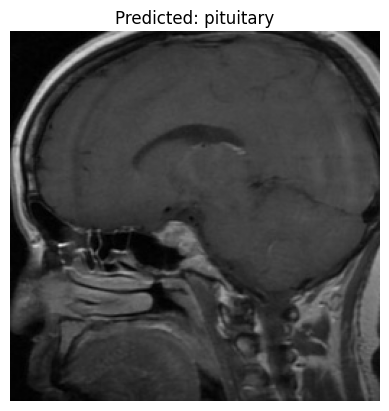

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image

# ==== STEP 1: Load Image ====
img_path = '/content/final_augmented_dataset/Testing/pituitary/Te-piTr_0004.jpg'

# Load with OpenCV
img_cv = cv2.imread(img_path)
img_cv = cv2.resize(img_cv, (256, 256))  # Resize to match model input

# Convert BGR to RGB
img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

# Prepare image for prediction
img_array = img_rgb / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)  # (1, 256, 256, 3)

# ==== STEP 2: Predict Class ====
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)

# Get label mapping
class_indices = train_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}
predicted_label = class_labels[predicted_class_index]

# ==== STEP 3: Display Image and Prediction ====
plt.imshow(img_rgb)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()

### Plot training and validation accuracy

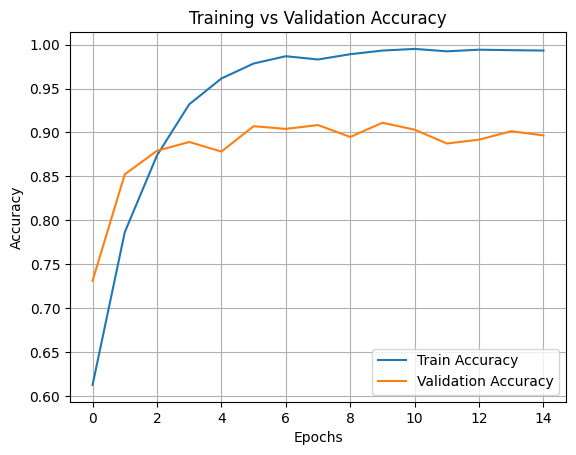

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Plot training and validation loss

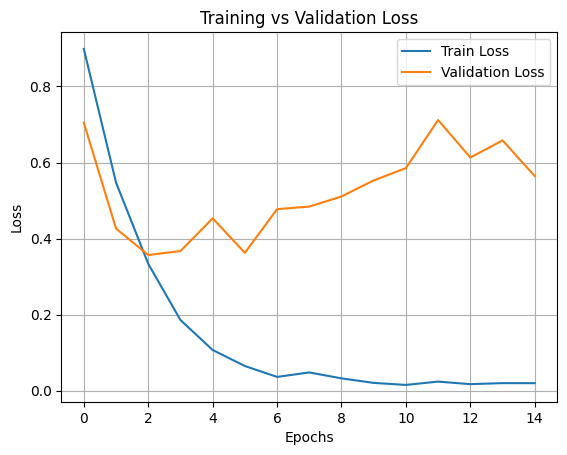

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

### Install libraries for quantum models

In [ ]:
!pip install pennylane
!pip install pennylane-qiskit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.9/249.9 kB 22

## Quantum Circuit Definition

This code defines a simple **quantum circuit** using PennyLane to simulate quantum operations on 4 qubits.

1. **Quantum Circuit Setup**:
   - The circuit is created with **4 qubits** using the default.qubit simulator.
   
2. **Angle Embedding**:
   - The **AngleEmbedding** template encodes classical inputs into quantum states.

3. **Basic Entangling Layers**:
   - **BasicEntanglerLayers** applies entangling gates (e.g., CNOTs) to the qubits, controlled by the `weights`.

4. **Measurement**:
   - The circuit measures the expectation values of the **Pauli-Z** operator for each qubit.

This setup is used for quantum-classical hybrid models, where the quantum circuit can be trained using classical data.


In [ ]:
import pennylane as qml
from pennylane import numpy as np

n_qubits = 4  # Number of qubits
dev = qml.device("default.qubit", wires=n_qubits)  # Simple simulator

# Define Quantum Circuit
@qml.qnode(dev, interface="tf")
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

## Quantum Layer Integration

This code adds a **quantum layer** to a Keras model using PennyLane.

- **Weight Shapes**: Defines 6 layers of entanglers, each with `n_qubits` weights.
- **KerasLayer**: Wraps the quantum circuit for use in Keras, enabling hybrid quantum-classical models.


In [ ]:
from tensorflow.keras import layers

# Create weight shapes for PennyLane
weight_shapes = {"weights": (6, n_qubits)}  # 6 layers of entanglers

# PennyLane KerasLayer
qlayer = qml.qnn.KerasLayer(quantum_circuit, weight_shapes, output_dim=n_qubits)

/usr/local/lib/python3.11/dist-packages/pennylane/qnn/keras.py:317: PennyLaneDeprecationWarning: The 'KerasLayer' class is deprecated and will be removed in v0.42. 
  warnings.warn(



###  Hybrid Quantum CNN with CBAM Model Explanation

This function defines a **hybrid quantum-classical convolutional neural network (CNN)** enhanced with the **Convolutional Block Attention Module (CBAM)**. The model combines classical deep learning layers with quantum computing layers for image classification tasks.

####  Model Overview

- **Input Shape**: `(256, 256, 3)` — expects RGB images of size 256x256.
- **Output Classes**: Defaults to 4 classes (can be changed).
- **Architecture Type**: Hybrid Classical-Quantum CNN with attention (CBAM).

####  Step-by-Step Architecture

1. **Classical CNN Backbone**
   - Starts with three sets of `Conv2D + MaxPooling2D` layers:
     - First: 32 filters
     - Second: 64 filters
     - Third: 128 filters
   - All use `3x3` kernels with `'same'` padding and ReLU activation.
   - Each Conv layer is followed by a MaxPooling layer of size `2x2`, reducing spatial dimensions progressively.

2. **CBAM Attention Block**
   - After the CNN feature extractor, a **CBAM block** is applied.
   - CBAM stands for **Convolutional Block Attention Module**, which enhances informative features and suppresses less useful ones.
   - It includes:
     - **Channel Attention**: Highlights important channels.
     - **Spatial Attention**: Focuses on important spatial regions.
   - This helps the model learn more discriminative features.

3. **Feature Flattening**
   - Output from CBAM is flattened into a 1D vector using `Flatten()`.

4. **Dimensionality Reduction**
   - A dense layer reduces the number of features to match the number of **quantum input qubits** (`4_qubits`).
   - Uses ReLU activation.

5. **Quantum Layer**
   - Applies a quantum circuit as a differentiable layer (`qlayer`) using frameworks like **PennyLane with Keras**.
   - Processes the reduced classical features using quantum operations.
   - The quantum layer outputs a vector that can be fed into classical post-processing.

6. **Classical Post-Processing**
   - Dense layer with 512 units and ReLU activation.
   - Dropout layer (rate = 0.5) to prevent overfitting.
   - Final output layer with `num_classes` units and `softmax` activation for multi-class classification.

####  Hybrid Nature

- Combines **classical CNNs** (for feature extraction), **CBAM** (for attention-based enhancement), and a **quantum layer** (for quantum-enhanced decision-making).
- Allows leveraging both classical deep learning performance and quantum computing capabilities.


In [ ]:
def build_hybrid_quantum_cnn_cbam(input_shape=(256, 256, 3), num_classes=4):
    inputs = Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # CBAM Block
    x = cbam_block(x)

    x = layers.Flatten()(x)

    # Reduce dimension for quantum input (must be <= number of qubits)
    x = layers.Dense(n_qubits, activation='relu')(x)

    # Quantum Layer
    x = qlayer(x)

    # Classical Layers
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

### Compile the Hybrid Model

In [ ]:
model_hybrid = build_hybrid_quantum_cnn_cbam()

model_hybrid.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_hybrid.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 256, 256,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 128, 128,  │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ max_pooling2d_5[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ max_pooling2d_5[… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │      2,064 │ global_average_p… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │      2,176 │ dense_4[0][0],    │
│                     │                   │            │ dense_4[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128)       │          0 │ dense_5[0][0],    │
│                     │                   │            │ dense_5[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128)       │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 128) │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 32, 32,    │          0 │ max_pooling2d_5[… │
│ (Multiply)          │ 128)              │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 32, 32, 1) │          0 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 32, 32, 1) │          0 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32, 2) │          0 │ lambda_2[0][0], 

 Total params: 626,515 (2.39 MB)

 Trainable params: 626,515 (2.39 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Hybrid Model

In [ ]:
epochs = 15
batch_size = 32

# Train the hybrid model
history_hybrid = model_hybrid.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/15


286/286 ━━━━━━━━━━━━━━━━━━━━ 66s 156ms/step - accuracy: 0.3157 - loss: 1.3422 - val_accuracy: 0.4814 - val_loss: 1.0973
Epoch 2/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 50s 85ms/step - accuracy: 0.4992 - loss: 0.9757 - val_accuracy: 0.5357 - val_loss: 0.9961
Epoch 3/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 24s 84ms/step - accuracy: 0.5533 - loss: 0.8991 - val_accuracy: 0.6010 - val_loss: 0.9400
Epoch 4/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 24s 84ms/step - accuracy: 0.5883 - loss: 0.8504 - val_accuracy: 0.5799 - val_loss: 0.9267
Epoch 5/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 25s 86ms/step - accuracy: 0.6330 - loss: 0.7938 - val_accuracy: 0.6583 - val_loss: 0.8423
Epoch 6/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 25s 87ms/step - accuracy: 0.6971 - loss: 0.7015 - val_accuracy: 0.6925 - val_loss: 0.7715
Epoch 7/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 41s 86ms/step - accuracy: 0.7350 - loss: 0.6223 - val_accuracy: 0.7096 - val_loss: 0.7772
Epoch 8/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 25s 85ms/step - accuracy: 0.8070 - loss: 0.4976 - val_accura

### Evaluate on Test Set

In [ ]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc * 100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.8622 - loss: 0.7802
Test Accuracy: 89.78%


### Comparing accuracy between Classical and Hybrid Model

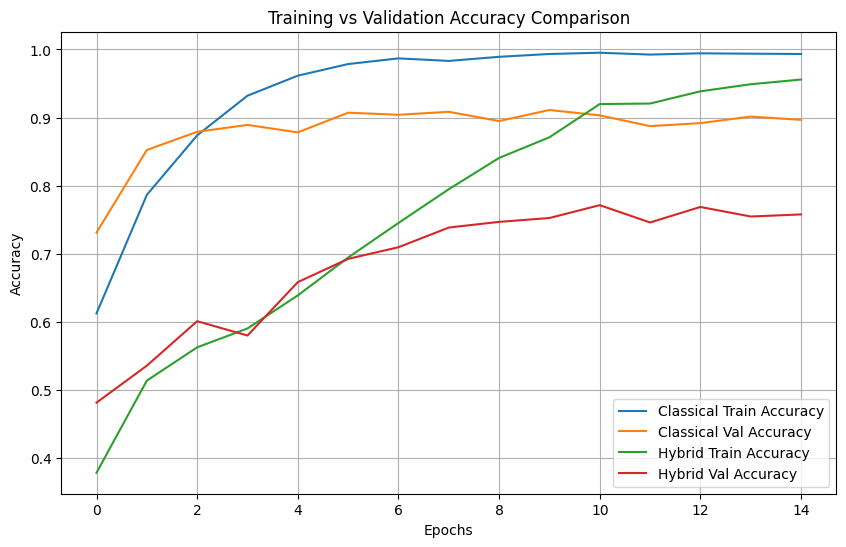

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Classical Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Classical Val Accuracy')
plt.plot(history_hybrid.history['accuracy'], label='Hybrid Train Accuracy')
plt.plot(history_hybrid.history['val_accuracy'], label='Hybrid Val Accuracy')
plt.title('Training vs Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Comparing loss between Classical and Hybrid Model

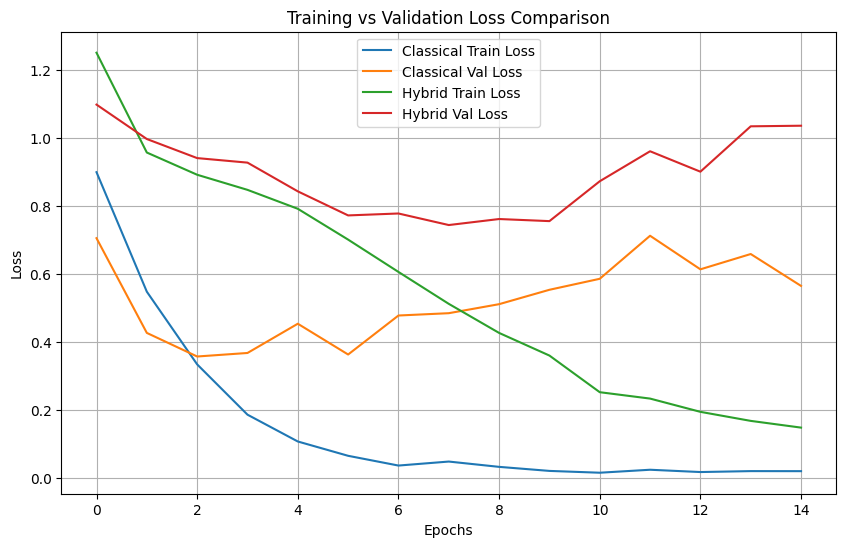

In [ ]:
# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Classical Train Loss')
plt.plot(history.history['val_loss'], label='Classical Val Loss')
plt.plot(history_hybrid.history['loss'], label='Hybrid Train Loss')
plt.plot(history_hybrid.history['val_loss'], label='Hybrid Val Loss')
plt.title('Training vs Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Explainability via Grad Cam
#### make_gradcam_heatmap() : Generates a heatmap showing which image regions influenced the model’s prediction.
####show_gradcam() : Displays the original image and the heatmap overlay side by side.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Function to generate Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps input image to activations + output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Get feature maps and prediction
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute the gradients of top predicted class wrt output feature map
    grads = tape.gradient(class_channel, conv_outputs)

    # Compute guided gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Plot heatmap on original image
def show_gradcam(img_path, model, last_conv_layer_name):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Same normalization

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
    plt.axis('off')
    plt.title("Grad-CAM Heatmap")

    plt.show()

### Testing Explainability through an example

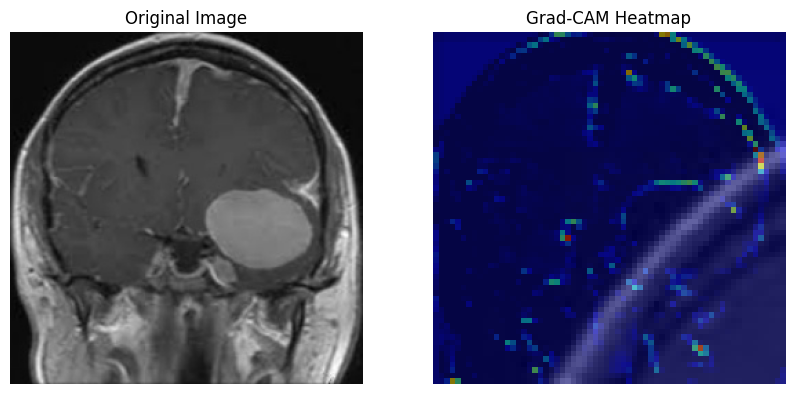

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_30']]
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


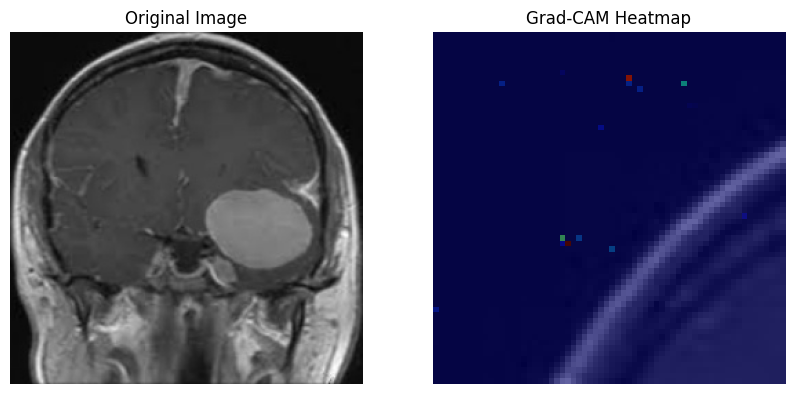

In [ ]:
# For Classical Model
show_gradcam('/content/final_augmented_dataset/Testing/meningioma/Te-me_0086.jpg', model, last_conv_layer_name='conv2d_2')

# For Hybrid Quantum Model
show_gradcam('/content/final_augmented_dataset/Testing/meningioma/Te-me_0086.jpg', model_hybrid, last_conv_layer_name='conv2d_6')